# NSGA-II Searcher example

This is an example about how using NSGAIISearcher for multi-objectives optimization.


## 1. Import modules and prepare data

In [1]:
from hypernets.utils import logging as hyn_logging
from hypernets.searchers.nsga_searcher import RNSGAIISearcher

from hypergbm import make_experiment

from hypernets.tabular import get_tool_box
from hypernets.tabular.datasets import dsutils
from hypernets.core.random_state import get_random_state

#hyn_logging.set_level(hyn_logging.WARN)
random_state = get_random_state()

df = dsutils.load_bank().head(1000)
tb = get_tool_box(df)
df_train, df_test = tb.train_test_split(df, test_size=0.2, random_state=9527)

## 2. Run an experiment within NSGAIISearcher

In [2]:
experiment = make_experiment(df_train,
                             eval_data=df_test.copy(),
                             callbacks=[],
                             random_state=1234,
                             search_callbacks=[],
                             target='y',
                             searcher='nsga2',  # available MOO searcher: moead, nsga2, rnsga2
                             searcher_options={'population_size': 10},
                             reward_metric='logloss',
                             objectives=['nf'],
                             early_stopping_rounds=10)

estimators = experiment.run(max_trials=10)
hyper_model = experiment.hyper_model_
hyper_model.searcher

NSGAIISearcher(objectives=[PredictionObjective(name=logloss, scorer=make_scorer(log_loss, needs_proba=True), direction=min), NumOfFeatures(name=nf, sample_size=1000, direction=min)], recombination=SinglePointCrossOver(random_state=RandomState(MT19937))), mutation=SinglePointMutation(random_state=RandomState(MT19937), proba=0.7)), survival=<hypernets.searchers.nsga_searcher._RankAndCrowdSortSurvival object at 0x000002177944F6A0>), random_state=RandomState(MT19937)

## 3. Summary trails

In [3]:
df_trials = hyper_model.history.to_df().copy().drop(['scores', 'reward'], axis=1)
df_trials[df_trials['non_dominated'] == True]

,trial_no,succeeded,elapsed,non_dominated,model_index,reward_logloss,reward_nf
0,1,True,0.461761,True,0.0,0.256819,0.3750
3,4,True,3.794317,True,1.0,0.540632,0.0000
4,5,True,0.321852,True,2.0,0.217409,0.6875
7,8,True,1.844163,True,3.0,0.164959,0.9375
8,9,True,1.606298,True,4.0,0.190964,0.8750
9,10,True,0.716679,True,5.0,0.218916,0.4375


## 4. Plot pareto font

We can pick model accord to Decision Maker's preferences from the pareto plot, the number in the figure indicates the index of pipeline models.


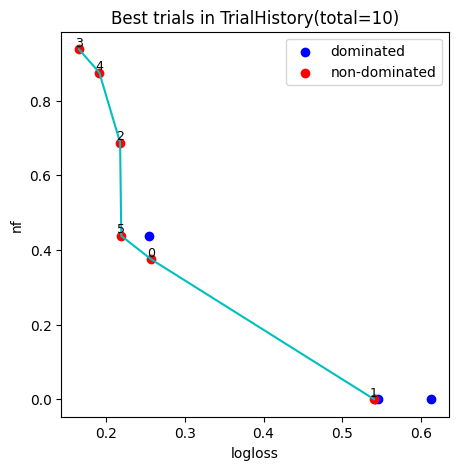

In [4]:
fig, ax  = hyper_model.history.plot_best_trials()
fig.show()

## 5. Plot population

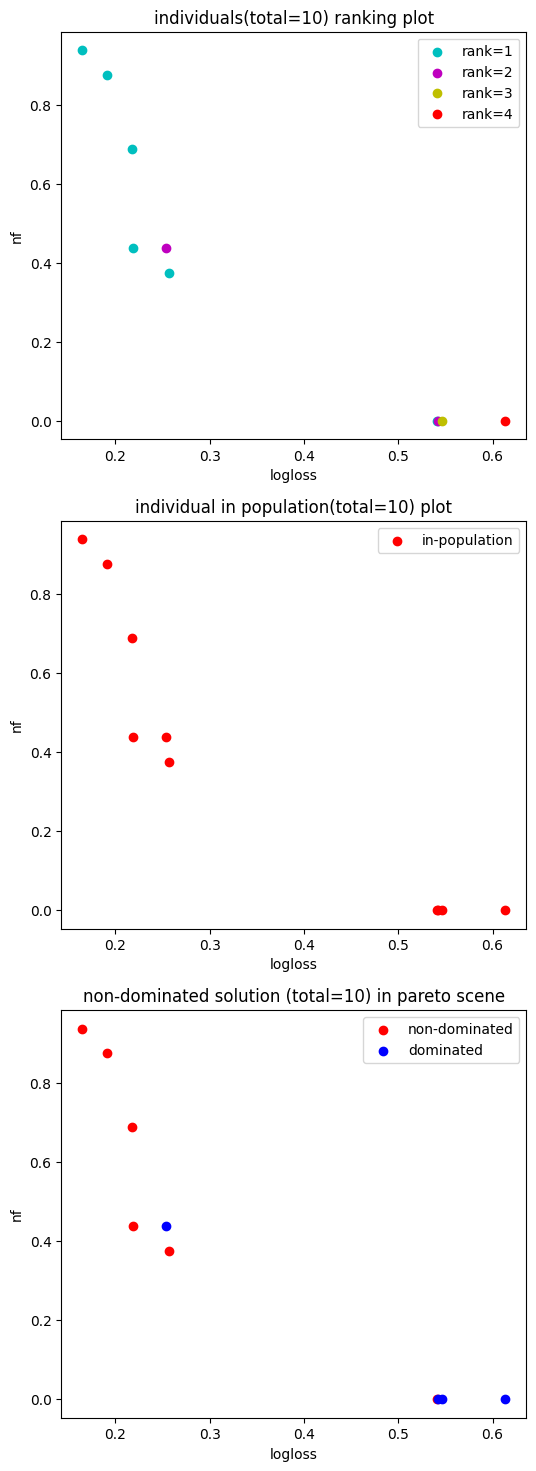

In [5]:
fig, ax  = hyper_model.searcher.plot_population()
fig.show()

## 6. Evaluate the selected model

In [6]:
print(f"Number of pipeline: {len(estimators)} ")

pipeline_model = estimators[0]  # selection the first pipeline model
X_test = df_test.copy()
y_test = X_test.pop('y')

preds = pipeline_model.predict(X_test)
proba = pipeline_model.predict_proba(X_test)

tb.metrics.calc_score(y_test, preds, proba, metrics=['auc', 'accuracy', 'f1', 'recall', 'precision'], pos_label="yes")

Number of pipeline: 6 


{'auc': 0.826357886904762,
 'accuracy': 0.84,
 'f1': 0.23809523809523808,
 'recall': 0.15625,
 'precision': 0.5}